In [16]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries


## Loading data and creating atom group of ions

In [17]:
u = mda.Universe('md.gro', 'md.xtc')
print(u, '\n', u.atoms, '\n', u.trajectory)

u.transfer_to_memory()

ions= u.select_atoms('resname NA CL')
print(len(u.trajectory))

waters=u.select_atoms('resname SOL')
nas=u.select_atoms('resname NA')
cls=u.select_atoms('resname CL')

box_size = u.dimensions[:3] * angstrom
print(box_size)
print(box_size/2)
wall1=box_size[2]/2-24*angstrom
#wall1=72.27*angstrom - 24*angstrom
print(wall1)
wall2=box_size[2]/2+24*angstrom
#wall2=72.27*angstrom +24*angstrom
print(wall2)

<Universe with 33430 atoms> 
 <AtomGroup [<Atom 1: OW of type O of resname SOL, resid 66 and segid SYSTEM>, <Atom 2: HW1 of type H of resname SOL, resid 66 and segid SYSTEM>, <Atom 3: HW2 of type H of resname SOL, resid 66 and segid SYSTEM>, ..., <Atom 33428: OW of type O of resname SOL, resid 11165 and segid SYSTEM>, <Atom 33429: HW1 of type H of resname SOL, resid 11165 and segid SYSTEM>, <Atom 33430: HW2 of type H of resname SOL, resid 11165 and segid SYSTEM>]> 
 <XTCReader md.xtc with 1001 frames of 33430 atoms>
1001
[ 48.  48. 144.] A
[24. 24. 72.] A
48.0 A
96.0 A


## Function for calculating osmotic values:

In [18]:

R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

def osmotic_values(mean_force_wall, molarity :Quantity, vant_hoff : int=2, T=300*kelvin, cross_sectional_area : Quantity=48*48 * angstrom**2 ):
    osm_press=mean_force_wall/cross_sectional_area
    osm_bar = osm_press.in_units_of(bar / mole)
    osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
    print(f"Osmotic Pressure Observed:", osm_bar)
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    print(f"Osmotic Pressure Ideal:", osm_press_ideal)
    osm_coeff=osm_bar/osm_press_ideal
    #osm_coeff=(osm_bar/(vant_hoff* molarity * R * T))*101.32 #Osmotic pressure to osmotic coefficient
    print(f"Osmotic Coefficient:", osm_coeff)

    return osm_coeff

def calculate_net_force(z_values : np.ndarray[float], zwall : float, k : float) -> float:
    return k * abs(z_values - zwall).sum()

In [19]:
k_nm = 4184 * kilojoule_per_mole / nanometer**2
k = k_nm.in_units_of(kilojoule_per_mole / angstrom**2)

walls_z_pos = np.array([48, 96]) * angstrom
forces_at_ts = {
    48 : [],
    96 : []
}

for _ in u.trajectory:
    ions_z = ions.positions[:,2]*angstrom
    force_48 = calculate_net_force(
        z_values=ions_z[ions_z < wall1],
        zwall=wall1,
        k=k
    )
    forces_at_ts[48].append(force_48)

    force_96 = calculate_net_force(
        z_values=ions_z[ions_z > wall2],
        zwall=wall2,
        k=k
    )
    forces_at_ts[96].append(force_96)

mean_forces = {
    abs_wall_z : sum(force_list, start=0*(kilojoule_per_mole / angstrom)) / len(u.trajectory)
        for abs_wall_z, force_list in forces_at_ts.items()
}

mean_forces

{48: Quantity(value=5.163277604963392, unit=kilojoule/(angstrom*mole)),
 96: Quantity(value=5.331079182658189, unit=kilojoule/(angstrom*mole))}

In [20]:
box_x = box_size[0]
box_y = box_size[1]

A_box = box_x * box_y 

dim_mem = walls_z_pos.ptp() * walls_z_pos.unit
V_mem = A_box * dim_mem
print(V_mem)

n_part = 65
M = n_part / (V_mem * AVOGADRO_CONSTANT_NA)
M = M.in_units_of(mole / litre)
print(M)

for wall_z_val, mF in mean_forces.items():
    print(wall_z_val)
    o = osmotic_values(mF, molarity=M, cross_sectional_area=A_box)

110592.0 A**3
0.9759751100106702 mol/L
48
Osmotic Pressure Observed: 37.21277854906911 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7643071474317701
96
Osmotic Pressure Observed: 38.422158216150784 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7891463978062171


In [21]:
av_mF=(mean_forces[48]+mean_forces[96])/2
o = osmotic_values(av_mF, molarity=M, cross_sectional_area=A_box)

Osmotic Pressure Observed: 37.817468382609945 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.7767267726189936


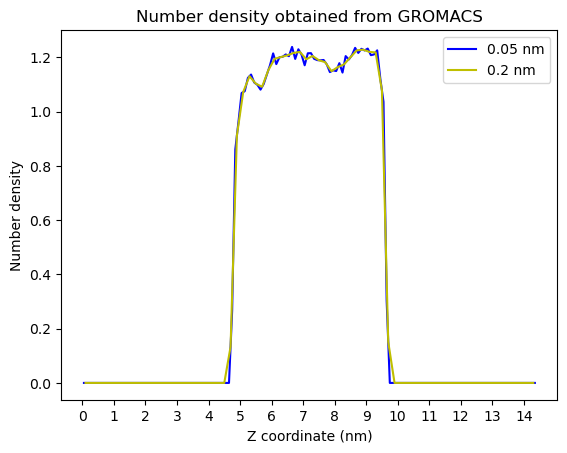

In [40]:
x,y = np.loadtxt("density_20ns.xvg",comments=["@", "#"],unpack=True)
x2,y2 = np.loadtxt("density_20ns_72.xvg",comments=["@", "#"],unpack=True)
plt.plot(x,y, c='b', label='0.05 nm')
plt.plot(x2,y2, c='y', label='0.2 nm')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Number density")
plt.xticks(np.arange(0, 14.4, 1.0))
plt.title('Number density obtained from GROMACS')
plt.legend()
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

In [ ]:
x,y = np.loadtxt("density_20ns.xvg",comments=["@", "#"],unpack=True)
x2,y2 = np.loadtxt("density_5ns.xvg",comments=["@", "#"],unpack=True)
plt.plot(x,y, c='b', label='20 ns')
plt.plot(x2,y2, c='m', label='5 ns')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Number density")
plt.xticks(np.arange(0, 14.4, 1.0))
plt.legend()
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

In [23]:
ions_at_48=[]
ions_at_96=[]
zpositions=[]

for _ in u.trajectory:
    ions_z = ions.positions[:,2]*angstrom
    zpositions.append(ions_z)
    z_values48=ions_z[ions_z < wall1]
    z_values96=ions_z[ions_z > wall2]
    ions_at_48.append(z_values48)
    ions_at_96.append(z_values96)

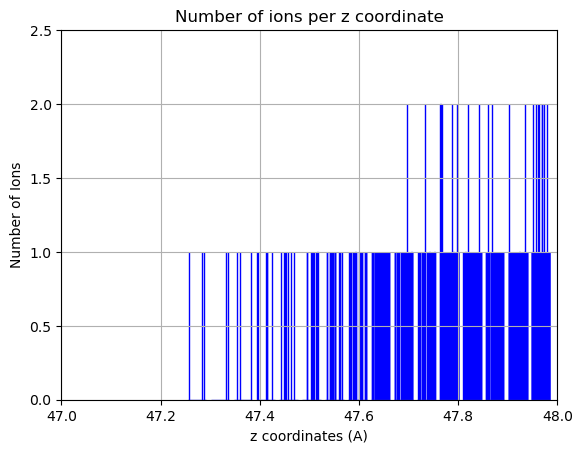

In [24]:
plt.hist(ions_at_48,bins='auto',edgecolor='blue')
plt.xlabel('z coordinates (A)')
plt.ylabel('Number of Ions')
plt.title('Number of ions per z coordinate')
plt.axis([47, 48, 0, 2.5])
# Display the plot
plt.grid(True)
plt.show()


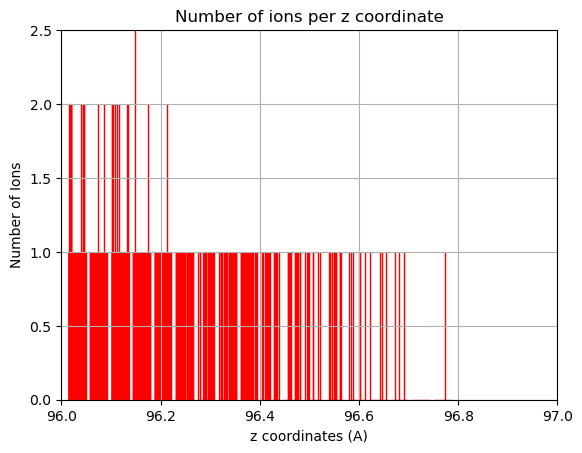

In [25]:
plt.hist(ions_at_96,bins='auto',edgecolor='red')
plt.xlabel('z coordinates (A)')
plt.ylabel('Number of Ions')
plt.title('Number of ions per z coordinate')
plt.axis([96, 97, 0, 2.5])
plt.grid(True)
plt.show()

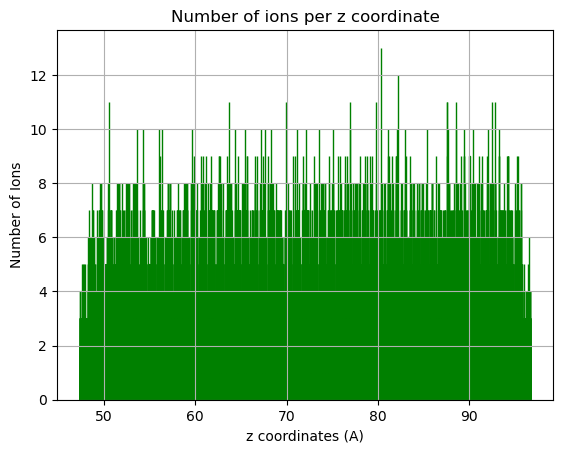

In [26]:
plt.hist(zpositions,bins='auto',edgecolor='green')
plt.xlabel('z coordinates (A)')
plt.ylabel('Number of Ions')
plt.title('Number of ions per z coordinate')
plt.grid(True)
plt.show()


In [27]:
list48=forces_at_ts[48]
list96=forces_at_ts[96]
f48=[]
f96=[]
time=[]
for i,ts in enumerate(u.trajectory):
    time.append(u.trajectory.time)
    val48=list48[i]
    val96=list96[i]
    f48.append(val48.item())
    f96.append(val96.item())


print(f48)
print(time)

[0.0, 1.2549893188476564, 0.8366595458984376, 0.0, 0.0, 7.531212768554688, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5102978515625, 0.0, 0.0, 0.0, 0.0, 10.041510620117188, 15.480755310058594, 0.0, 0.8366595458984376, 9.204531860351564, 4.602425537109375, 28.032563781738283, 0.0, 0.0, 18.827872314453128, 0.0, 0.4183297729492188, 25.940595703125002, 6.694074401855469, 0.0, 7.949542541503907, 21.338170166015626, 0.0, 0.0, 0.0, 0.0, 7.949542541503907, 1.6736383056640627, 5.020755310058594, 0.0, 0.0, 6.275904235839844, 0.0, 13.807117004394533, 0.0, 0.0, 11.296659545898438, 26.77725524902344, 12.13347869873047, 0.0, 0.0, 0.0, 0.0, 1.2549893188476564, 0.0, 30.543021240234378, 3.3471170043945313, 0.0, 0.0, 0.0, 6.275904235839844, 8.367872314453125, 21.338170166015626, 0.0, 0.0, 0.0, 18.409542541503907, 36.400436096191406, 6.694234008789063, 0.0, 48.53407440185547, 15.062265930175782, 0.0, 0.0, 36.81892547607422, 0.0, 7.531212768554688, 4.602425537109375, 0.0, 0.0, 0.0, 4.183776550292969, 0.0, 2.5102978515625

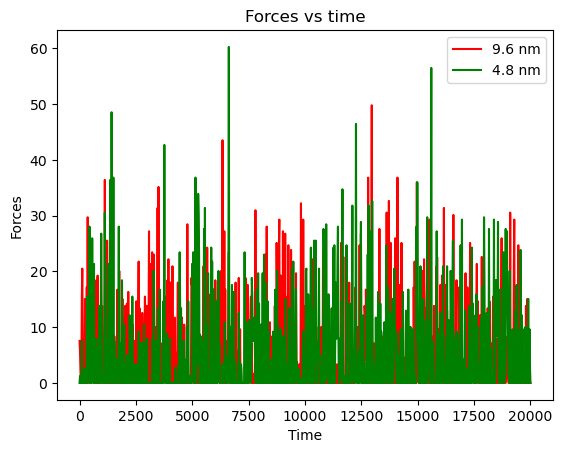

In [28]:
plt.plot(time,f96, color='r', label='9.6 nm')
plt.plot(time,f48, color='g', label='4.8 nm')
plt.ylabel("Forces")
plt.xlabel("Time")
plt.title("Forces vs time")
plt.legend()
plt.show()

In [29]:
fts48=np.array(f48)
fts96=np.array(f96)

np.set_printoptions(threshold=np.inf)
print(fts48)



[ 0.          1.25498932  0.83665955  0.          0.          7.53121277
  0.          0.          0.          0.          0.          2.51029785
  0.          0.          0.          0.         10.04151062 15.48075531
  0.          0.83665955  9.20453186  4.60242554 28.03256378  0.
  0.         18.82787231  0.          0.41832977 25.9405957   6.6940744
  0.          7.94954254 21.33817017  0.          0.          0.
  0.          7.94954254  1.67363831  5.02075531  0.          0.
  6.27590424  0.         13.807117    0.          0.         11.29665955
 26.77725525 12.1334787   0.          0.          0.          0.
  1.25498932  0.         30.54302124  3.347117    0.          0.
  0.          6.27590424  8.36787231 21.33817017  0.          0.
  0.         18.40954254 36.4004361   6.69423401  0.         48.5340744
 15.06226593  0.          0.         36.81892548  0.          7.53121277
  4.60242554  0.          0.          0.          4.18377655  0.
  2.51029785  1.67363831  8.36787231

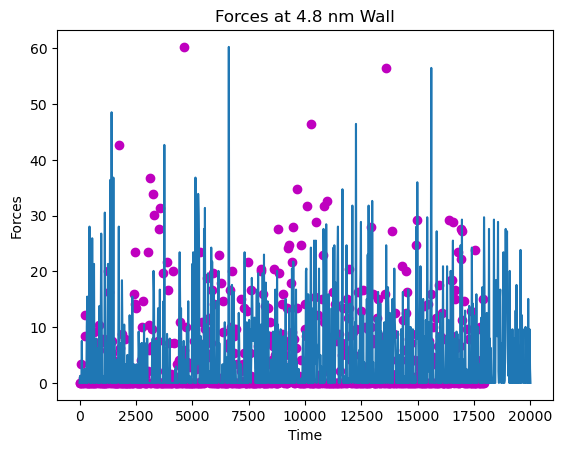

In [30]:
nskip=100
t0, g, Neff_max = timeseries.detect_equilibration(fts48,nskip=nskip) # compute indices of uncorrelated timeseries
fts48_equil = fts48[t0:]
indices48 = timeseries.subsample_correlated_data(fts48_equil, g=g)
fts48_s = fts48_equil[indices48]

indt48=[]
for i in indices48:
    indt48.append(time[i])

plt.plot(time,f48)
plt.scatter(indt48, fts48_s, color='m', marker='o')
plt.ylabel("Forces")
plt.xlabel("Time")
plt.title("Forces at 4.8 nm Wall")
plt.show()

[0.0, 40.0, 80.0, 120.0, 160.0, 200.0, 240.0, 280.0, 300.0, 340.0, 380.0, 420.0, 460.0, 500.0, 540.0, 580.0, 620.0, 660.0, 700.0, 740.0, 780.0, 820.0, 840.0, 880.0, 920.0, 960.0, 1000.0, 1040.0, 1080.0, 1120.0, 1160.0, 1200.0, 1240.0, 1280.0, 1320.0, 1360.0, 1400.0, 1420.0, 1460.0, 1500.0, 1540.0, 1580.0, 1620.0, 1660.0, 1700.0, 1740.0, 1780.0, 1820.0, 1860.0, 1900.0, 1940.0, 1980.0, 2000.0, 2040.0, 2080.0, 2120.0, 2160.0, 2200.0, 2240.0, 2280.0, 2320.0, 2360.0, 2400.0, 2440.0, 2480.0, 2520.0, 2540.0, 2580.0, 2620.0, 2660.0, 2700.0, 2740.0, 2780.0, 2820.0, 2860.0, 2900.0, 2940.0, 2980.0, 3020.0, 3060.0, 3100.0, 3120.0, 3160.0, 3200.0, 3240.0, 3280.0, 3320.0, 3360.0, 3400.0, 3440.0, 3480.0, 3520.0, 3560.0, 3600.0, 3640.0, 3660.0, 3700.0, 3740.0, 3780.0, 3820.0, 3860.0, 3900.0, 3940.0, 3980.0, 4020.0, 4060.0, 4100.0, 4140.0, 4180.0, 4220.0, 4240.0, 4280.0, 4320.0, 4360.0, 4400.0, 4440.0, 4480.0, 4520.0, 4560.0, 4600.0, 4640.0, 4680.0, 4720.0, 4760.0, 4800.0, 4820.0, 4860.0, 4900.0, 4940.

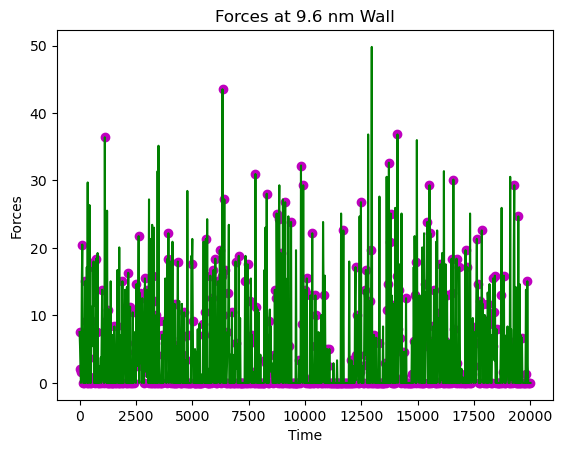

[0, 2, 4, 6, 8, 10, 12, 14, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209, 211, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259, 261, 263, 265, 267, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 297, 299, 301, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 353, 355, 357, 359, 361, 363, 365, 367, 369, 371, 373, 375, 377, 379, 381, 382, 384, 386, 388, 390, 392, 394, 396, 398, 400, 402, 404, 406, 4

In [35]:
nskip=100
t0, g, Neff_max = timeseries.detect_equilibration(fts96,nskip=nskip) # compute indices of uncorrelated timeseries
fts96_equil = fts96[t0:]
indices96 = timeseries.subsample_correlated_data(fts96_equil, g=g)
fts96_s = fts96_equil[indices96]

indt96=[]
for i in indices96:
    indt96.append(time[i])
print(indt96)

plt.plot(time, f96, c='g')
plt.scatter(indt96, fts96_s, color='m', marker='o')
plt.ylabel("Forces")
plt.xlabel("Time")
plt.title("Forces at 9.6 nm Wall")
plt.show()

print(indices96)

In [32]:
from MDAnalysis.analysis import density
from tqdm import tqdm
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [33]:
nbins2,ncounts2=density_profile(u,ions,2)
nbins4,ncounts4=density_profile(u,ions,4)
nbins6,ncounts6=density_profile(u,ions,6)


Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [02:51<00:00,  5.83it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [01:25<00:00, 11.71it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: NA of type NA of resname NA, resid 1 and segid SYSTEM>, <Atom 11102: NA of type NA of resname NA, resid 2 and segid SYSTEM>, <Atom 11103: NA of type NA of resname NA, resid 3 and segid SYSTEM>, ..., <Atom 11228: CL of type CL of resname CL, resid 63 and segid SYSTEM>, <Atom 11229: CL of type CL of resname CL, resid 64 and segid SYSTEM>, <Atom 11230: CL of type CL of resname CL, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [00:55<00:00, 17.89it/s]


72
36
24


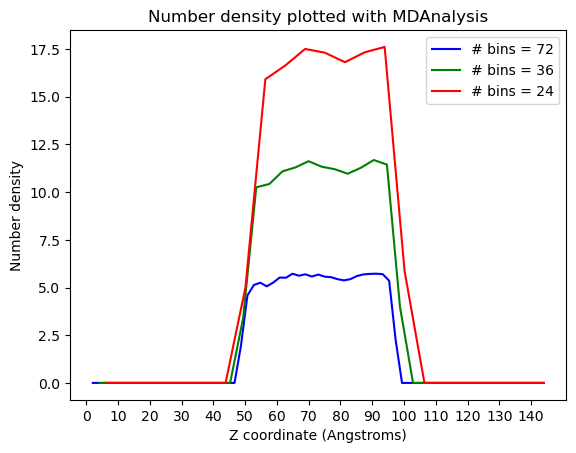

In [34]:
print(len(nbins2))
print(len(nbins4))
print(len(nbins6))
plt.plot(nbins2[1:],ncounts2, c='b', label='# bins = 72')
plt.plot(nbins4[1:],ncounts4, c='g', label='# bins = 36')
plt.plot(nbins6[1:],ncounts6, c='r', label='# bins = 24')
plt.xlabel("Z coordinate (Angstroms)")
plt.ylabel("Number density")
plt.xticks(np.arange(0, 144, 10))
plt.title("Number density plotted with MDAnalysis")
plt.legend()
plt.show()